In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:

def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [4]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [5]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [6]:
print(t.shape)

(10,)


In [7]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [8]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

We can choose MSE for error measure and we write following codes to show log-log plot.

In [ ]:


# Set number of Monte Carlo samples
num_samples = 10000

# Set different numbers of time steps to simulate
num_steps_list = [1, 10, 50, 100, 500, 1000, 5000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


In [ ]:
# Set number of Monte Carlo samples
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

# Set different numbers of time steps to simulate
num_steps = 5000

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


Exercise 2

In [13]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

class DGM_Layer(nn.Module):
    """ 
    Defines a PyTorch module DGM_Layer which implements a single layer of a deep gated network.
    The activation parameter specifies the activation function to be used in the layer
    """
    def __init__(self, dim_x, dim_S, activation='Tanh'):


        super(DGM_Layer, self).__init__()
        

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            
        
        # The module has four gates
        # Z gate (update gate): controls how much of the previous state to keep and how much of the new input to include in the current state. 
        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        # G gate (reset gate): controls how much of the previous state to forget and how much of the new input to remember. 
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        # R gate (reset signal): controls how much of the input to use to modify the current state.
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        # H gate (hidden state): produces a candidate hidden state that can be added to the current state. 
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    


    def forward(self, x, S):
        # concatenates  input 'x' and the hidden state 'S' along the feature dimension
        x_S = torch.cat([x,S],1)
        
        
        # passes the concatenated tensor through each of the four gates. 
        Z = self.gate_Z(x_S) # how much of the new state to keep
        G = self.gate_G(x_S) # how much proportion of the previous state to keep
        R = self.gate_R(x_S) # the proportion of the input to use to modify the current state.

        
        input_gate_H = torch.cat([x, S*R],1) # 'R*S' is modified state
        H = self.gate_H(input_gate_H)  #  candidate hidden state, and is the amount of information from the current input to add to the new state

        
        # The resulting tensors are then combined to compute the new hidden state S for the next time step, which is returned as output.
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        """
        dim_x is the dimension of the input tensor,
        dim_S is the number of hidden units in each of the three DGM_Layer objects,
        activation is the activation function used in the hidden layers, which can be ReLU, Tanh, Sigmoid, or LogSigmoid.
        The constructor initializes the class variables using the arguments, and creates the layers of the neural network.
        """
        super(Net_DGM, self).__init__()
      
        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)
        # The input_layer is a linear layer followed by an activation function, which takes a concatenation of t and x as input
        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        """
        DGM1, DGM2, and DGM3 are three layers of the Deep Gaussian Process (DGP) model. 
        They are initialized with 
        dim_x+1 as input dimension (where the +1 accounts for the time input t), 
        dim_S as output dimension, and the activation function specified in the constructor.
        """
        self.output_layer = nn.Linear(dim_S, 1)
        # The output_layer is a linear layer that takes the output from the last DGM layer as input and produces a single output value.
        
    def forward(self,t,x):
        # The forward method defines the forward pass of the neural network, which takes two input tensors t and x and returns a single output tensor.
        # t and x are concatenated along the second dimension using torch.cat to create a single input tensor.
        tx = torch.cat([t,x], 1)

        # This input tensor is then passed through the input_layer to obtain S1, which is then passed through DGM1, DGM2, and DGM3 to obtain S4.
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)

        # Finally, S4 is passed through the output_layer to obtain the output of the neural network, which is returned.
        output = self.output_layer(S4)
        return output


      
        

In [14]:
T = 1 # time horizon
hidden_size = 100 # hidden layer size = 100
lr = 0.01 # the learning rate for the optimizer
num_epochs = 10000 # the number of iterations the optimizer will perform to train the neural network

net = Net_DGM(2, hidden_size)
# neural network is defined using the Net_DGM class with input dimension of 2 

optimizer = optim.Adam(net.parameters(), lr=lr)
# initializes the Adam optimizer with the learning rate lr and the parameters of the neural network net. 
# The net.parameters() method returns an iterable of all the trainable parameters in the neural network net. 

criterion = nn.MSELoss()
# The mean squared error (MSE) loss function is defined using the nn.MSELoss() class.

losses = [] # empty list prepared for value of the loss
for epoch in tqdm(range(num_epochs)):
    #  t is a randomly selected value between 0 and T, which can be used as a time parameter for some stochastic process.
    t = np.random.uniform(0, T)
    # Two random numbers between -3 and 3 are generated and stored in the list x
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    # An LQR object is created
    lqr = LQR(H, M, sigma, C, R, D, 1)

    # true value of the solution to the LQR problem
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    # optimizer's gradient is reset to zero
    optimizer.zero_grad()
    # predict the value of the solution to the LQR problem at time t and state x
    y_pred = net(torch.tensor([[t]], dtype=torch.float32), torch.tensor([x]))

    # The MSE loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)

    # gradients of the neural network's parameters
    loss.backward()
    # optimizer takes a step in the negative direction of the gradients
    optimizer.step()

    losses.append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/30/5npdvf4d7mb7d1df8ndd9dmm0000gn/T/ipykernel_99859/4034920402.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
100%|██████████| 10000/10000 [00:58<00:00, 170.88it/s]


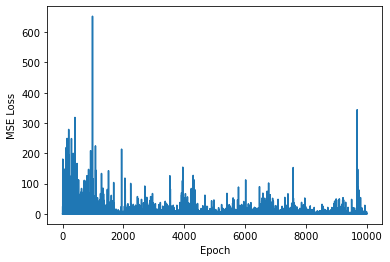

In [15]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [16]:
class FFN(nn.Module):
    """ 
    define a fully-connected feed-forward neural network.
    sizes: a list of integers specifying the number of neurons in each layer of the neural network.
    activation: an activation function to apply between hidden layers. By default, the ReLU activation function is used.
    output_activation: an activation function to apply to the output layer. By default, the identity function is used.
    batch_norm: a boolean flag indicating whether or not to apply batch normalization between layers. By default, this flag is set to False.
    """

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    


    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    """ 
    used to freeze and unfreeze the weights of the neural network, respectively. 
    When the weights are frozen, their gradients are not computed during backpropagation, effectively making them untrainable. 
    When the weights are unfrozen, their gradients are computed during backpropagation and the weights can be trained.
    """


    def forward(self, x):
        return self.net(x)
        # method is used to define the forward pass of the neural network. 
        # The output tensor of the last layer is returned as the output of the neural network.

In [8]:
net = FFN([3, 100, 100, 2]) # A feedforward neural network is defined
optimizer = optim.Adam(net.parameters(), lr=lr) # Adam optimizer is defined with the learning rate specified
criterion = nn.MSELoss() # A mean squared error loss function is defined.

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]

    # obtain the true value of the output at time t given the initial state x.
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))

    # reset the gradients in the optimizer to zero
    optimizer.zero_grad()

    # Concatenate two tensors horizontally and pass through the neural network in a single operation
    # ensure that the values of t and x are processed together by the neural network, rather than separately.
    tx = torch.cat([torch.tensor([[t]], dtype=torch.float32), torch.tensor([x])], 1)
    # use the neural network to predict the value of the solution to the LQR problem at time 't' and state 'x'
    y_pred = net(tx)

    # loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)
    # gradients of the neural network's parameters
    loss.backward()

    # update the model parameters to optimize the model parameters such that the loss function is minimized.
    optimizer.step()
    losses.append(loss.item())

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\jsbhq\AppData\Local\Temp\ipykernel_7784\792609944.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
C:\Users\jsbhq\.conda\envs\dev\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 89.11it/s]


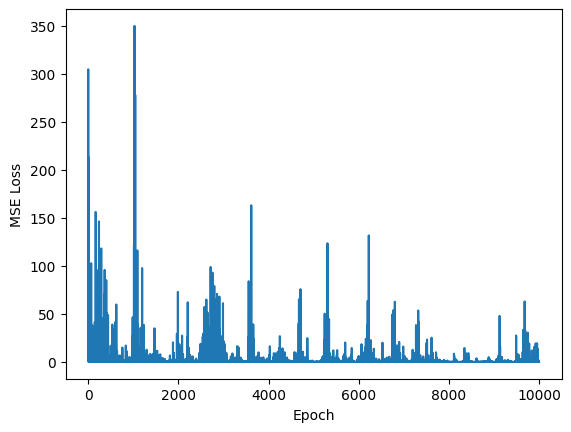

In [9]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()